# Create Map for the City of New Orleans

New Orleans maps are created by this notebook

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy
from datetime import datetime
import os
import pyproj

In [2]:
outPath = f"output{os.sep}"
dataPath = f"datasets{os.sep}"
wgs84 = pyproj.CRS.from_string('WGS84')

In [3]:
def lp(v):
    print(f"[{datetime.now()}] {v}")

lp("Starting...")

[2025-04-08 09:42:09.516354] Starting...


In [4]:
lp(f"outPath:  {outPath}")
lp(f"dataPath:  {dataPath}")

[2025-04-08 09:42:09.522167] outPath:  output/
[2025-04-08 09:42:09.522671] dataPath:  datasets/


In [5]:
lp("Loading 100m lidar data")
data100m = gpd.read_parquet(f"{outPath}PostProcessedLidat_100m.parquet")
bounds100m = data100m.total_bounds

[2025-04-08 09:42:09.528164] Loading 100m lidar data


In [6]:
lp("Loading 10m lidar data")
data10m = gpd.read_parquet(f"{outPath}PostProcessedLidat_10m.parquet")
data10m.loc[np.isnan(data10m['MeanAltitude']), 'MeanAltitude'] = pd.NA   #na values are numpy not pandas IDK
bounds10m = data100m.total_bounds

[2025-04-08 09:42:09.609057] Loading 10m lidar data


In [7]:
crs = data100m.crs
lp(f"CRS:  {crs.name}")

[2025-04-08 09:42:15.056621] CRS:  NAD83(2011) / UTM zone 15N + NAVD88 height - Geoid18 (metres)


In [8]:
lp("Creating CRS transformers")
crsToWgs84 = pyproj.Transformer.from_crs(crs_from=crs, crs_to=wgs84)
lp(crsToWgs84)

[2025-04-08 09:42:15.063473] Creating CRS transformers
[2025-04-08 09:42:15.079471] proj=pipeline step inv proj=utm zone=15 ellps=GRS80 step proj=unitconvert xy_in=rad xy_out=deg step proj=axisswap order=2,1


In [9]:
lp("Loading neighborhoos data")
neighborhoodsDf = gpd.read_file(f"{dataPath}Neighborhoods.geojson").set_index('gnocdc_lab').to_crs(crs)
neighborhoodsDf.head(2)

[2025-04-08 09:42:15.083365] Loading neighborhoos data


,neigh_id,objectid,lup_lab,shape_stlength,shape_starea,geometry
gnocdc_lab,,,,,,
B. W. COOPER,12D,6,B. W. COOPER HOUSING DEV,12118.012710324232,8808477.0902902912,"MULTIPOLYGON (((781325.808 3316870.195, 781298..."
HOLY CROSS,15C,32,HOLY CROSS,21187.180302661334,26999609.302162763,"MULTIPOLYGON (((788931.478 3317916.911, 788404..."


In [10]:
lp("Loading water")
waterDf = gpd.read_file(f"{dataPath}WATER2.SHP").set_crs(wgs84).to_crs(crs)

[2025-04-08 09:42:15.149045] Loading water


/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received an unexpected geometry.  Either a polygon with interior rings, or a polygon with less than 4 points, or a non-Polygon geometry.  Return arguments as a collection.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 3 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geometry of polygon of fid 4 cannot be translated to Simple Geometry. All polygons will be contained in a multipolygon.
  return ogr_read(
/home/g/.local/share/virtualenvs/NewOrleansElevation-1OW7m-mh/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Geom

In [11]:
data100m.columns

Index(['geometry', 'AltitudeTotal', 'WaterTotal', 'Int', 'Total', 'RunTime',
       'MeanAltitude', 'MeanIntensity', 'PercentWater', 'IsInterpolated'],
      dtype='object')

In [12]:
np.count_nonzero(data10m['Total'] > 0)

4034499

In [13]:
def tickPtFormater(pt):

    deg = int(pt)
    mins = round((pt - deg) * 60)
    
    return f"{deg}\u00B0 {mins}'"

def tickFormater(x,y):
    wgsPTS = crsToWgs84.transform(x,y)

    formated = tuple(map(tickPtFormater, wgsPTS))

    return formated

In [14]:
data100m.head(1)

,geometry,AltitudeTotal,WaterTotal,Int,Total,RunTime,MeanAltitude,MeanIntensity,PercentWater,IsInterpolated
76,"POLYGON ((776139 3315488, 776139 3315588, 7760...",0,0,0,0,0 days 00:00:00.228102,9.701096,626,0.137147,True


In [15]:
cartopyCRS = cartopy.crs.UTM(15)
def createMap(ax, df,column,bounds,vmin,vmax,cmap='seismic_r', alpha=0.5, tickSpacing=10000, zorderPlus = 0,\
             showColorBar=True,\
             bgColor=(1, 0.996, 0.859,1.0),\
             spineColor='black'):

    df = df.dropna(subset=column)
    normalizer = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    cmapTrans = matplotlib.colormaps.get_cmap(cmap)
    xMidpoint = bounds[2] - bounds[0]
    yMidpoint = bounds[3] - bounds[1]
    
    #data100m.plot(ax=ax,column='Altitude', legend=True)
    colors = cmapTrans( normalizer( df[column] ) )
    colors[:,3] = alpha

    plotMask = pd.isna(df[column])
    
    ax.patch.set_facecolor(bgColor)
    #ax.add_geometries(df['geometry'][~plotMask], crs=cartopyCRS, color=bgColor, edgecolor=None, zorder=4+zorderPlus)

    ax.add_geometries(df['geometry'], crs=cartopyCRS, color=colors, edgecolor=None, zorder=4+zorderPlus)

    waterDf.plot(ax=ax, color='lightblue', edgecolor='lightblue', label='water',zorder=5+zorderPlus)
    ax.add_geometries(df[df['PercentWater']>=50]['geometry'], crs=cartopyCRS, color='lightblue', edgecolor=None, zorder=6+zorderPlus)
    
    
    
    
    ax.set_xlim((bounds[0], bounds[2]))
    ax.set_ylim((bounds[1], bounds[3]))

    

    ax.xaxis.set_major_formatter(lambda x, pos: tickFormater(x,yMidpoint)[1])
    ax.yaxis.set_major_formatter(lambda y, pos: tickFormater(xMidpoint,y)[0])
    ax.tick_params(which='both')
    
    ax.set_xticks(np.arange(bounds[0]+tickSpacing, bounds[2], tickSpacing))
    ax.set_yticks(np.arange(bounds[1]+tickSpacing, bounds[3], tickSpacing))

    if showColorBar:
        matplotlib.pyplot.colorbar(mappable=matplotlib.cm.ScalarMappable(cmap=cmapTrans, norm=normalizer) , ax=ax)

    for spine in ax.spines.values():
        spine.set_edgecolor(spineColor)
        spine.set_zorder(100)

    ax.set_aspect('equal')

    return ax




In [16]:
def plotFig(subPlotHoods, dataSet = data100m, figsize = (17,10), dpi=120, vmin=-10, vmax = 10, cmap='RdYlGn'):
    
    startPlotTime = datetime.now()
    
    
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi, subplot_kw={ 'projection':cartopyCRS})
    createMap(ax, dataSet, 'MeanAltitude', dataSet.total_bounds , vmin=vmin, vmax=vmax, alpha=1, cmap=cmap)
    ax.set_title("New Orleans Elevation")
    
    
    
    for loc, hood, indicColor in subPlotHoods:
                
        geomHood = neighborhoodsDf.loc[hood,'geometry']
        geomBounds = shapely.buffer(geomHood, 100).bounds
        hoodMask = dataSet.intersects(geomHood)
    
        geomHeightRatio = ((geomBounds[3] - geomBounds[1]) / (geomBounds[2] - geomBounds[0]))
        
        loc.append( geomHeightRatio * loc[2] )
        
        axHood = ax.inset_axes(loc, projection=cartopyCRS, zorder=51)
        
        createMap(axHood, dataSet[hoodMask], 'MeanAltitude', geomBounds ,\
                  vmin=vmin, vmax=vmax, alpha=1, cmap=cmap,\
                  showColorBar=False,\
                 spineColor=indicColor)
    
        axHood.set_title(hood.title())
        ax.indicate_inset_zoom(axHood, zorder=50, edgecolor=indicColor)

        plt.close()

    return fig
    

[2025-04-08 09:42:15.225363] starting ploting


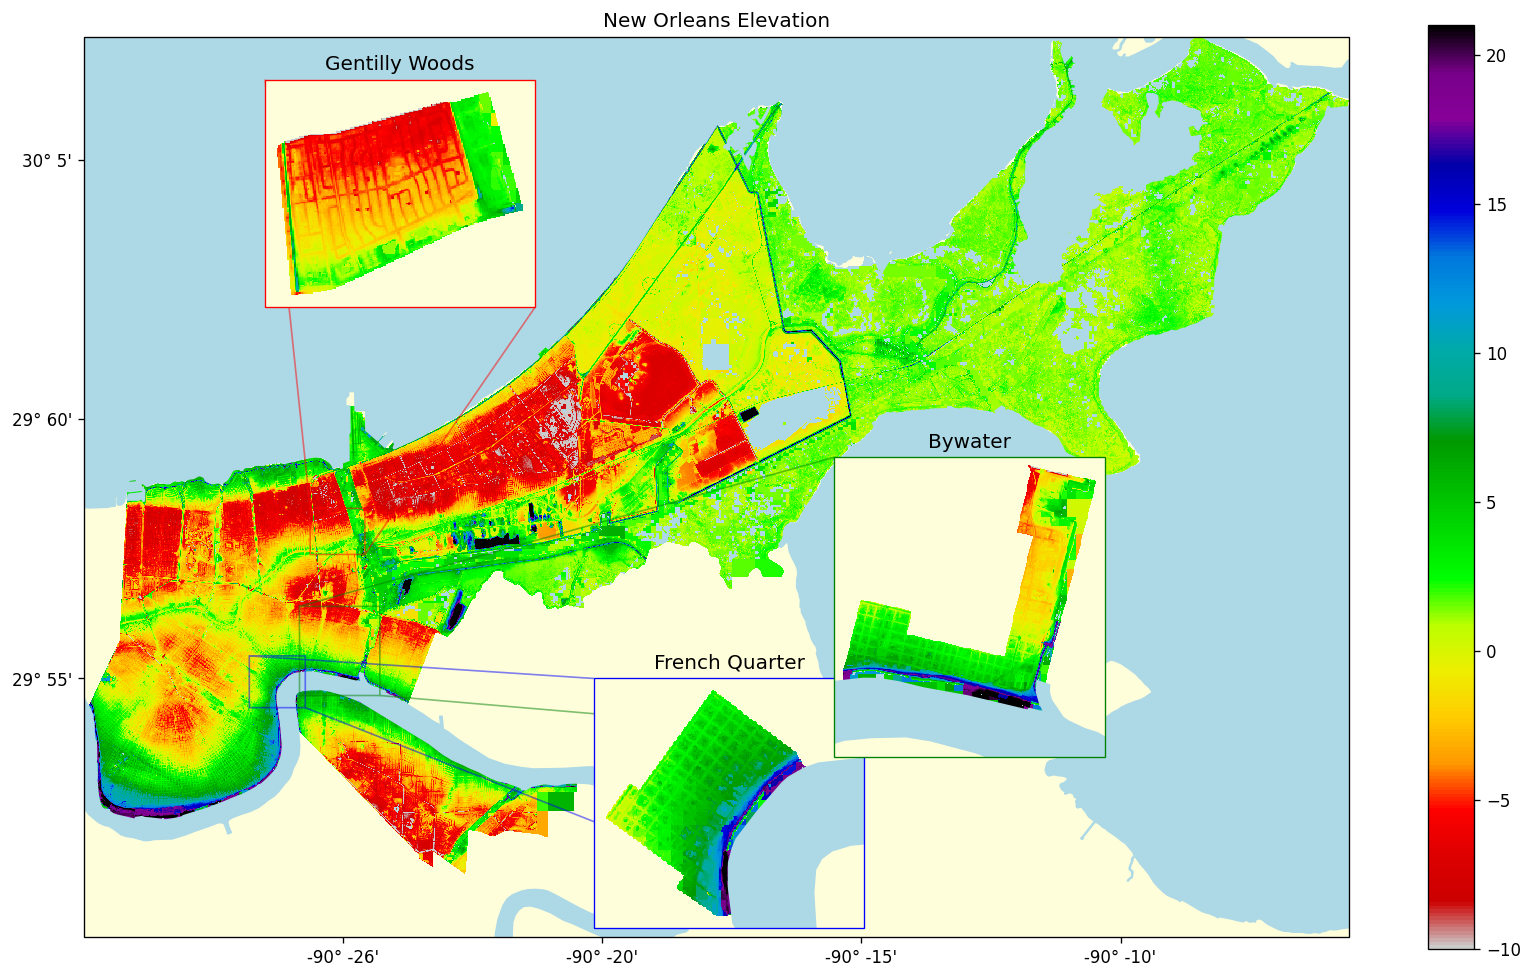

In [17]:
subPlotHoods = [
    [[0.1, 0.7, 0.3], 'GENTILLY WOODS', 'red'],
    #[[0.3,0.2,0.15], 'FRENCH QUARTER'],
    [[0.36, 0.01, 0.3], 'FRENCH QUARTER', 'blue'],
    [[0.55, 0.2, 0.3], 'BYWATER', 'green'],

]
lp("starting ploting")
fig = plotFig(subPlotHoods, data10m, vmin=-10, vmax=21, cmap='nipy_spectral_r')
fig.savefig("output/NewOrleans10m.jpg")
fig

In [18]:
lp("done")

[2025-04-08 09:53:11.628517] done
